In [ ]:
#Kết nối với drive cá nhân
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.7 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 49.3 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.7 MB/s 


In [ ]:
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 9.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=9d8122021683cf1f99cc3a4d7a12a2b070c67af64979a868604fed2406698811
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2022-05-31 15:28:22--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2022-05-31 15:28:23 (245 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2022-05-31 15:28:23--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
import os
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFAutoModel, AutoTokenizer
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score

In [ ]:
from vncorenlp import VnCoreNLP
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
import pandas as pd
data = pd.read_excel("/content/gdrive/MyDrive/Luan_van/data_crawl_1.xlsx", index_col=False)

In [ ]:
data_Sentiment = data['Sentiment']
data_Sentiment = data_Sentiment.astype(int)
data['Sentiment'] = data_Sentiment
data

,Text,Sentiment
0,"Đã bị nhiễm rồi, mà cũng bắt chích cho bằng được",0
1,thực sự thì tiêm xong yếu hẳn,1
2,Bắt buộc tiêm để được đi làm chứ tiêm xong yếu...,1
3,"Tiêm xong lắm bệnh vl, hụt hơi, mề đay, nóng gan",1
4,"Tiêm 2 mũi xong thấy giảm trí nhớ, tim đập nha...",1
...,...,...
7995,mấy bạn đừng kén chọn nữa em tiêm vacxin tàu x...,2
7996,Mình tiêm verocell đây. Phòng trọ 6 đứa thì 5 ...,2
7997,Mong được tiêm mà không được. Giờ có vaccine g...,2
7998,So ra thì mấy loại vaccine sản xuất từ mấy nướ...,2


In [ ]:
train, test= train_test_split(data, test_size=0.3, random_state=42)

In [ ]:
X_train = train['Text']
y_train = train['Sentiment'].values
X_test = test['Text']
y_test = test['Sentiment'].values

In [ ]:
#pre-process
import re
import numpy as np


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00000028-\U00000029"
        u"\U0000003A"
        u"\U0000003D"                   
                              "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized=True, lowercased=True):
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y
def preprocess_phobert(text, tokenized=True, lowercased=True):
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

In [ ]:
X_train, y_train = pre_process_features(X_train, y_train)
X_test, y_test = pre_process_features(X_test, y_test)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5600
  Num Epochs = 6
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2100


Step,Training Loss
25,1.087200
50,1.034700
75,0.971900
100,0.930000
125,0.811000
150,0.805100
175,0.740400
200,0.729800
225,0.714500
250,0.698800


Saving model checkpoint to /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-280
Configuration saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-280/config.json
Model weights saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-280/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-560
Configuration saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-560/config.json
Model weights saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-560/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-840
Configuration saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-840/config.json
Model weights saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-840/pytorch_model.bin
Saving model checkpoint to /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-1120
Configuration saved in /content/gdrive/MyDrive/Luan_van/phobert/checkpoint-1120/config.json
Model weigh

[[705  52  19]
 [ 31 734  69]
 [ 10  38 742]]
Acc: 0.90875
F1 - micro: 0.90875
F1 - macro: 0.9092886996744127
Acc: 0.90875


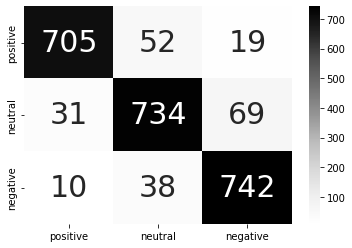

In [ ]:
# Phobert

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
import torch
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

train_X, train_y = pre_process_features(X_train, y_train, tokenized=False, lowercased = False)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=False, lowercased = False)
  
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)



class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        item["labels"] = torch.tensor(self.labels[idx])
        return item
       

    def __len__(self):
        return len(self.encodings["input_ids"])

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=300)

test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=300)

train_dataset = BuildDataset(train_encodings, train_y)

test_dataset = BuildDataset(test_encodings, test_y)

training_args = TrainingArguments(
    output_dir='/content/gdrive/MyDrive/Luan_van/phobert/',          
    num_train_epochs=6,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    
    save_steps =  280,  
    logging_steps = 25,             
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,  
    

               
)

trainer.train()
trainer.save_model("/content/gdrive/MyDrive/Luan_van/phobert/")
tokenizer.save_pretrained("/content/gdrive/MyDrive/Luan_van/phobert/")

y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

cf2 = confusion_matrix(y_true, y_pred)
print(cf2)

evaluation = f1_score(y_true, y_pred, average='micro')
acc = accuracy_score(y_true, y_pred)
print("Acc: " + str(acc))
print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

print("Acc: " + str(accuracy_score(y_true, y_pred)))


df_cm2 = pd.DataFrame(cf2, index = ["positive","neutral","negative"],
                  columns =  ["positive","neutral","negative"])
plt.clf()
sn.heatmap(df_cm2, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
target_names = ['Negative', 'Neutral', 'Positive']



In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.93      0.90      0.92       776
     Neutral       0.88      0.87      0.87       834
    Positive       0.89      0.93      0.91       790

    accuracy                           0.90      2400
   macro avg       0.90      0.90      0.90      2400
weighted avg       0.90      0.90      0.90      2400



In [ ]:
import torch
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/Luan_van/phobert", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

In [ ]:
%%capture
model.cuda()

In [ ]:
#dư đoán nhãn
import torch.nn.functional as F
import time

texts = "verocell tốt hơn astra"
texts = preprocess_phobert(texts)
#tokenized_texts = tokenizer(texts, return_tensors="pt")
tokenized_texts = tokenizer.encode_plus(texts, add_special_tokens = True, max_length=258,truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")
print(texts)
start = time.time()
y_pred_classify2 = model(tokenized_texts['input_ids'].cuda())
y_pred = torch.argmax(y_pred_classify2.logits)
end  = time.time()
t = end - start
#print(t)
if y_pred == 2:
  print("positive" )
if y_pred == 1:
  print("neutral" )
if y_pred == 0:
  print("negative" )

verocell tốt hơn astra
0.014511823654174805
positive
